In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import _tree
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import xgboost as xgb

## 1. Decision Trees as Interpretable Models

(a) Download the Accute Inflamations data from https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations.<br>
(b) Build a decision tree on the whole data set and plot it.1


In [2]:
names_col=["Temperature", "Nausea", "Lumbar_Pain", "Urine_Pushing", "Micturition_Pains", "Burning_Urethra", "Inflammation_of_Bladder", "Nephritis_of_Renal_Pelvis"]
df_diag = pd.read_excel("../hw5data/acute+inflammations/diagnosis.xlsx", header=None, names=names_col)
value_map = {"no": 0, "yes": 1}
df_diag.iloc[:,1:] = df_diag.iloc[:,1:].replace(value_map)

In [3]:
X_diag = df_diag.iloc[:,:6]
y1_diag = df_diag.iloc[:,-2]
y1_diag=y1_diag.astype('int')
y2_diag = df_diag.iloc[:,-1]
y2_diag=y2_diag.astype('int')
y_diag = np.vstack((y1_diag, y2_diag)).T

Classes for Decision Tree 1: [0 1]


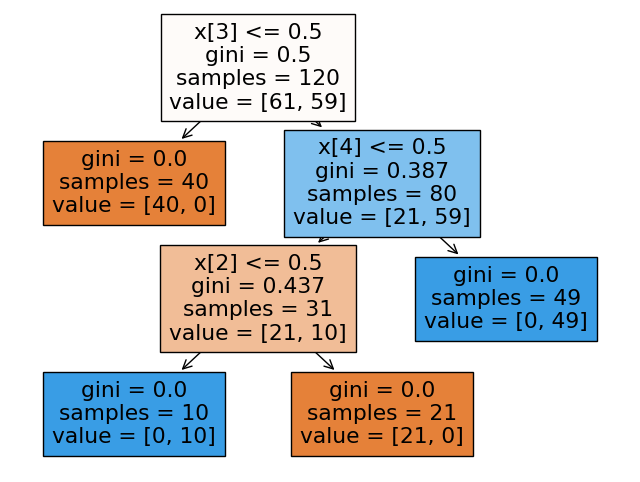

Classes for Decision Tree 2: [0 1]


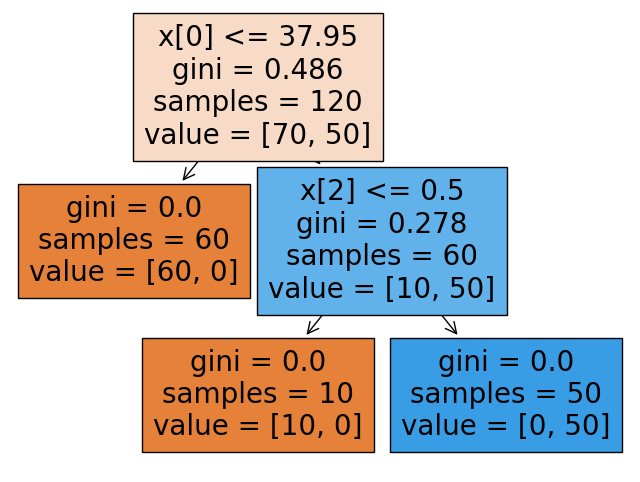

In [4]:
dt_model = DecisionTreeClassifier(random_state=0)
multi_target_dt = MultiOutputClassifier(dt_model).fit(X_diag, y_diag)

individual_trees = multi_target_dt.estimators_

for i, tree_model in enumerate(individual_trees):
    plt.figure(figsize=(8, 6))
    plt.title(f"Decision Tree {i+1}")

    classes = tree_model.classes_
    print(f"Classes for Decision Tree {i+1}: {classes}")

    tree.plot_tree(tree_model, filled=True)
    plt.show()

(c) Convert the decision rules into a set of IF-THEN rules.

In [5]:
def tree_to_code(tree, feature_names):

	tree_ = tree.tree_
	feature_name = [
		feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
		for i in tree_.feature
	]
	print("def tree({}):".format(", ".join(feature_names)))

	def recurse(node, depth):
		indent = "  " * depth
		if tree_.feature[node] != _tree.TREE_UNDEFINED:
			name = feature_name[node]
			threshold = tree_.threshold[node]
			print("{}if {} <= {}:".format(indent, name, threshold))
			recurse(tree_.children_left[node], depth + 1)
			print("{}else:  # if {} > {}".format(indent, name, threshold))
			recurse(tree_.children_right[node], depth + 1)
		else:
			print("{}return {}".format(indent, tree_.value[node]))

	recurse(0, 1)

In [6]:
for i, tree_model in enumerate(individual_trees):
    tree_to_code(tree_model, names_col)

def tree(Temperature, Nausea, Lumbar_Pain, Urine_Pushing, Micturition_Pains, Burning_Urethra, Inflammation_of_Bladder, Nephritis_of_Renal_Pelvis):
  if Urine_Pushing <= 0.5:
    return [[40.  0.]]
  else:  # if Urine_Pushing > 0.5
    if Micturition_Pains <= 0.5:
      if Lumbar_Pain <= 0.5:
        return [[ 0. 10.]]
      else:  # if Lumbar_Pain > 0.5
        return [[21.  0.]]
    else:  # if Micturition_Pains > 0.5
      return [[ 0. 49.]]
def tree(Temperature, Nausea, Lumbar_Pain, Urine_Pushing, Micturition_Pains, Burning_Urethra, Inflammation_of_Bladder, Nephritis_of_Renal_Pelvis):
  if Temperature <= 37.95000076293945:
    return [[60.  0.]]
  else:  # if Temperature > 37.95000076293945
    if Lumbar_Pain <= 0.5:
      return [[10.  0.]]
    else:  # if Lumbar_Pain > 0.5
      return [[ 0. 50.]]


(d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.

Classes for Decision Tree 1: [0 1]


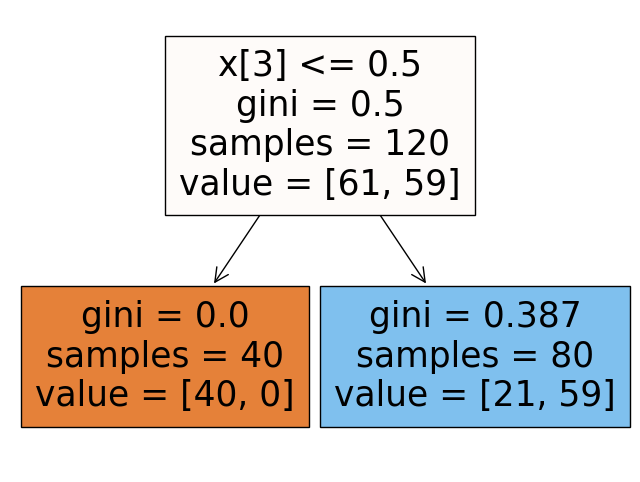

Classes for Decision Tree 2: [0 1]


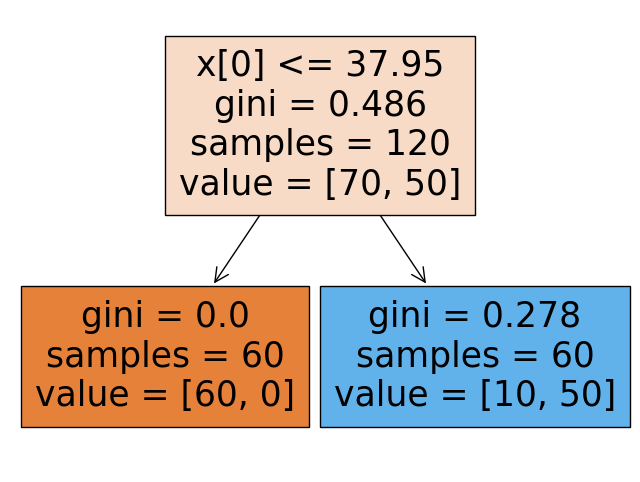

In [7]:
#A simpler model
dt_model2 = DecisionTreeClassifier(random_state=0, min_impurity_decrease=0.2)

multi_target_dt2 = MultiOutputClassifier(dt_model2).fit(X_diag, y_diag)

individual_trees = multi_target_dt2.estimators_

for i, tree_model in enumerate(individual_trees):
    plt.figure(figsize=(8, 6))
    plt.title(f"Decision Tree {i+1}")

    classes = tree_model.classes_
    print(f"Classes for Decision Tree {i+1}: {classes}")

    tree.plot_tree(tree_model, filled=True)
    plt.show()

In [8]:
individual_trees = multi_target_dt2.estimators_
for i, tree_model in enumerate(individual_trees):
    tree_to_code(tree_model, names_col)

def tree(Temperature, Nausea, Lumbar_Pain, Urine_Pushing, Micturition_Pains, Burning_Urethra, Inflammation_of_Bladder, Nephritis_of_Renal_Pelvis):
  if Urine_Pushing <= 0.5:
    return [[40.  0.]]
  else:  # if Urine_Pushing > 0.5
    return [[21. 59.]]
def tree(Temperature, Nausea, Lumbar_Pain, Urine_Pushing, Micturition_Pains, Burning_Urethra, Inflammation_of_Bladder, Nephritis_of_Renal_Pelvis):
  if Temperature <= 37.95000076293945:
    return [[60.  0.]]
  else:  # if Temperature > 37.95000076293945
    return [[10. 50.]]


## 2. The LASSO and Boosting for Regression

(a)(b)

In [9]:
names_col2=['state', 'county', 'community', 'communityname', 'fold', 'population', 'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 'PctLargHouseFam', 'PctLargHouseOccup', 'PersPerOccupHous', 'PersPerOwnOccHous', 'PersPerRentOccHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctHousOwnOcc', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart', 'OwnOccMedVal', 'OwnOccHiQuart', 'RentLowQ', 'RentMedian', 'RentHighQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet', 'PctForeignBorn', 'PctBornSameState', 'PctSameHouse85', 'PctSameCity85', 'PctSameState85', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 'PolicAveOTWorked', 'LandArea', 'PopDens', 'PctUsePubTrans', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn', 'PolicBudgPerPop', 'ViolentCrimesPerPop']

In [10]:
df_communities_org = pd.read_excel("../hw5data/communities+and+crime/communities.xlsx", header=None, names=names_col2)
df_communities = df_communities_org.iloc[:,5:] #Ignore the unpredictable columns
df_communities_train = df_communities.iloc[:1496,:]
df_communities_test = df_communities.iloc[1496:,:]

In [11]:
df_communities_train.replace("?", np.nan, inplace=True)
mean_values_train = df_communities_train.mean()
df_communities_train.fillna(mean_values_train, inplace=True)
X_train = df_communities_train.iloc[:,:-1]
y_train = df_communities_train.iloc[:,-1]

C:\Users\云忆\AppData\Local\Temp\ipykernel_24440\1614975110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_communities_train.replace("?", np.nan, inplace=True)


C:\Users\云忆\AppData\Local\Temp\ipykernel_24440\1614975110.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_communities_train.fillna(mean_values_train, inplace=True)


In [12]:
df_communities_test.replace("?", np.nan, inplace=True)
mean_values_test = df_communities_test.mean()
df_communities_test.fillna(mean_values_test, inplace=True)
X_test = df_communities_test.iloc[:,:-1]
y_test = df_communities_test.iloc[:,-1]

C:\Users\云忆\AppData\Local\Temp\ipykernel_24440\424359330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_communities_test.replace("?", np.nan, inplace=True)
C:\Users\云忆\AppData\Local\Temp\ipykernel_24440\424359330.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_communities_test.fillna(mean_values_test, inplace=True)


In [13]:
df_communities = pd.concat([df_communities_train,df_communities_test])
df_communities

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,0.160500,0.065375,0.655375,0.406250,0.00,0.208000,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,0.160500,0.065375,0.655375,0.406250,0.00,0.208000,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.080000,0.060000,0.780000,0.000000,0.91,0.280000,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.020000,0.020000,0.790000,0.000000,0.22,0.180000,0.19


(c) Plot a correlation matrix for the features in the data set

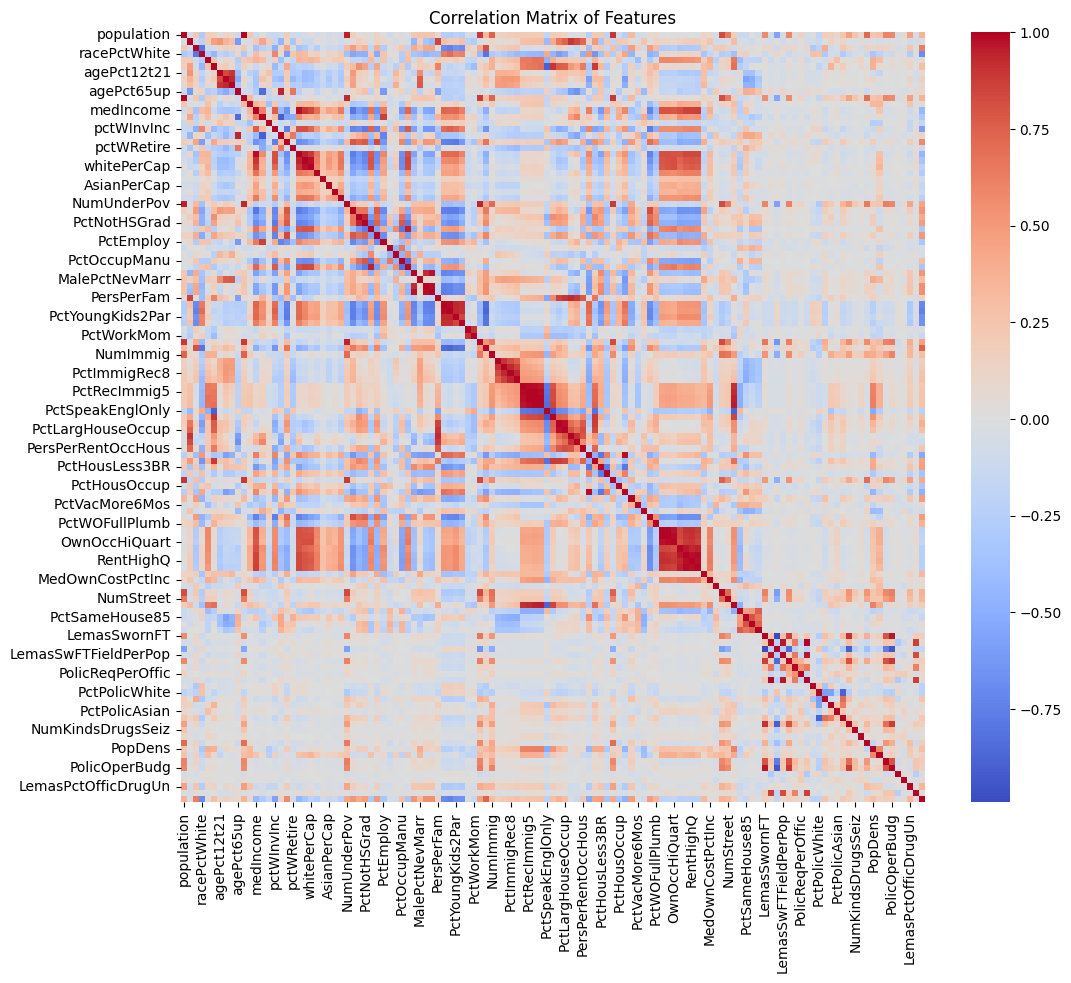

In [14]:
correlation_matrix = df_communities.corr()

plt.figure(figsize=(12, 10))
plt.title("Correlation Matrix")
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()

(d) Calculate the Coefficient of Variation CV for each feature, where CV = s/m , in which s is sample standard deviation and m is sample mean.

In [15]:
cv_values = (df_communities.std() / df_communities.mean()).sort_values(ascending=False)
cv_df = pd.DataFrame({'Feature': cv_values.index, 'Coefficient of Variation (CV)': cv_values.values})
print(cv_df)

                 Feature  Coefficient of Variation (CV)
0              NumStreet                       4.407702
1          NumInShelters                       3.485481
2               NumIlleg                       2.994196
3               NumImmig                       2.900497
4    LemasPctOfficDrugUn                       2.555266
..                   ...                            ...
118    NumKindsDrugsSeiz                       0.146403
119   RacialMatchCommPol                       0.132429
120  LemasPctPolicOnPatr                       0.126630
121        PctPolicWhite                       0.121713
122    LemasSwFTFieldOps                       0.057905

[123 rows x 2 columns]


(e) Pick sqrt(128) features with highest CV , and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots

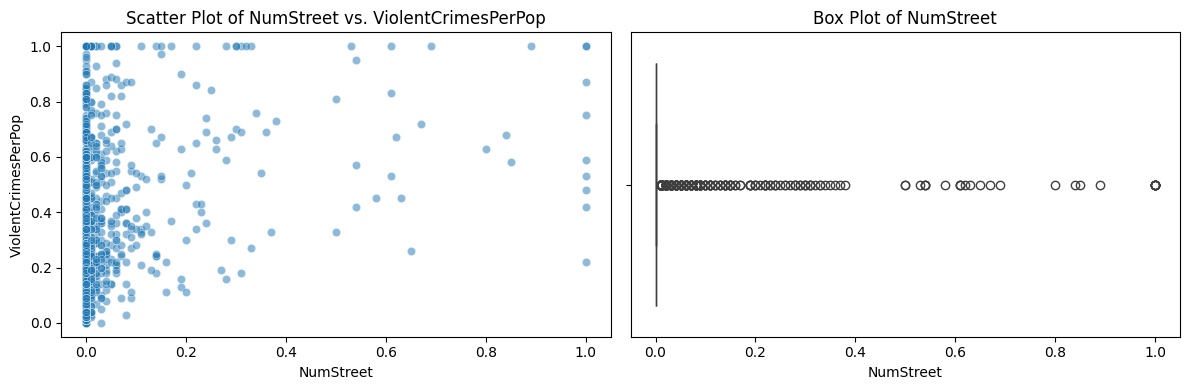

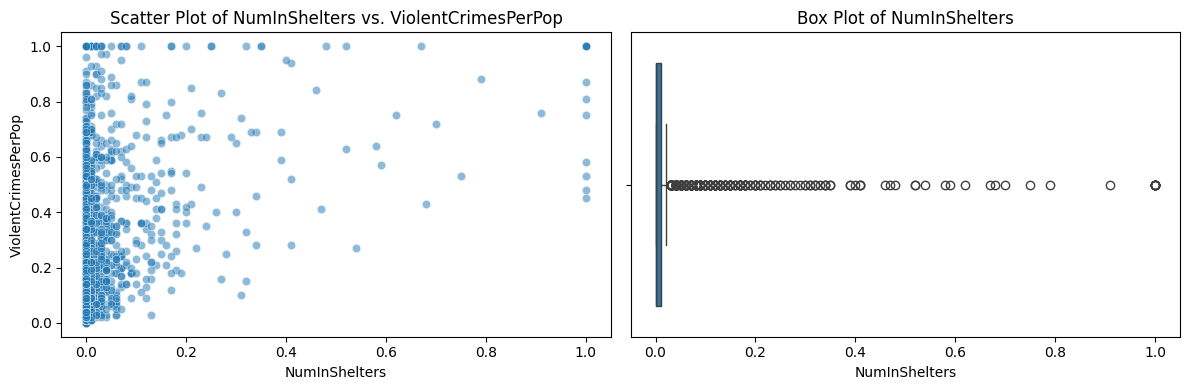

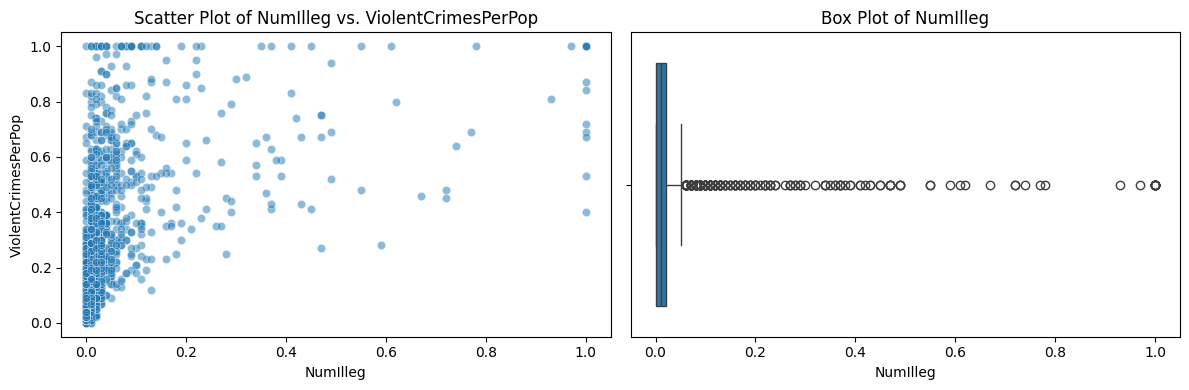

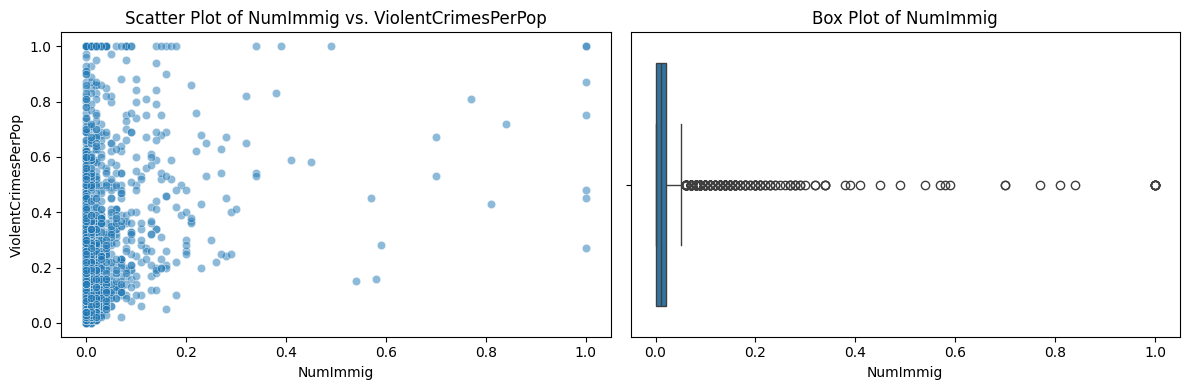

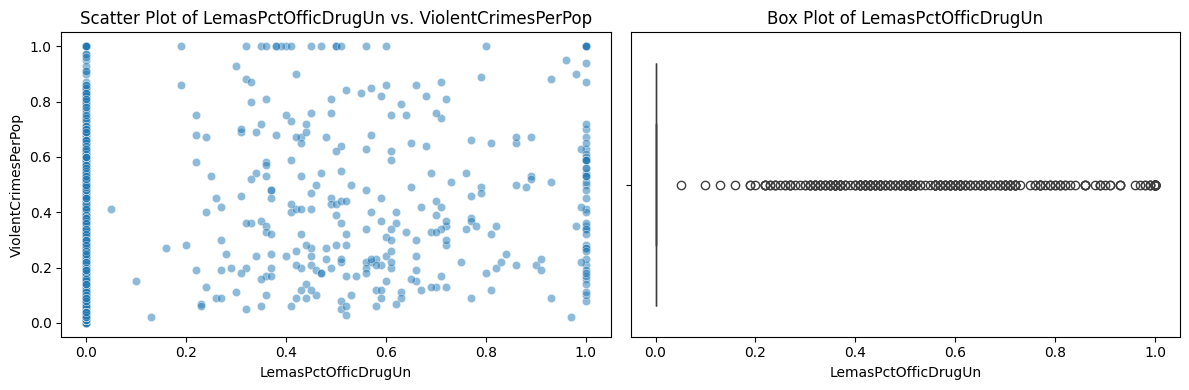

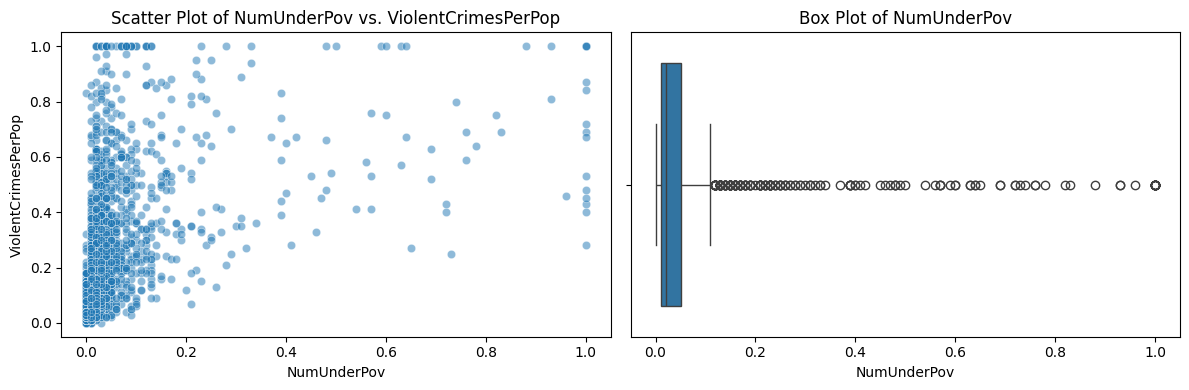

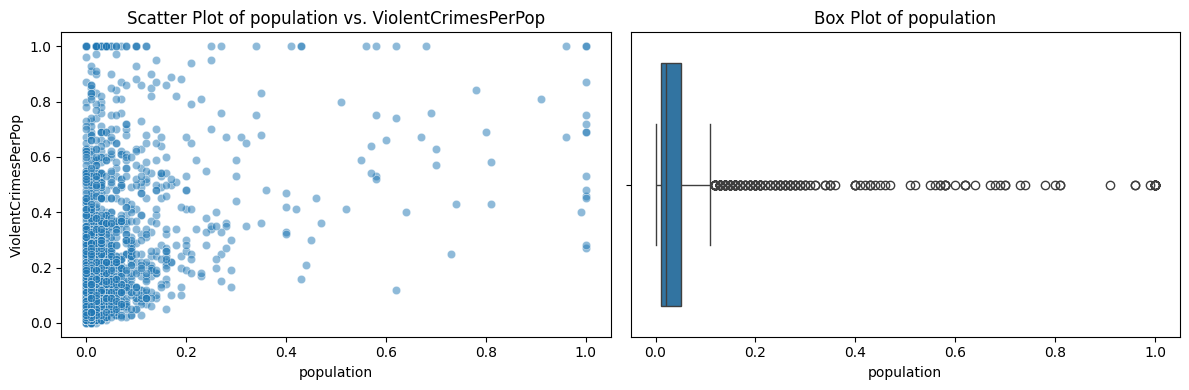

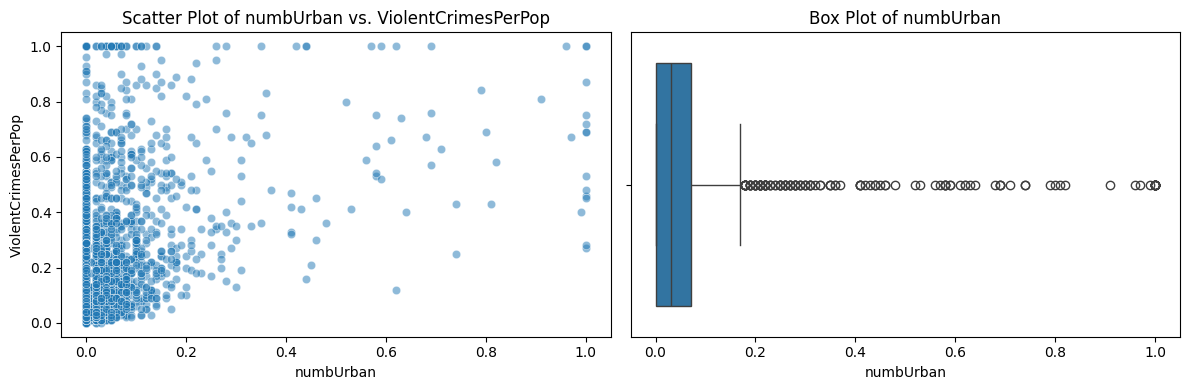

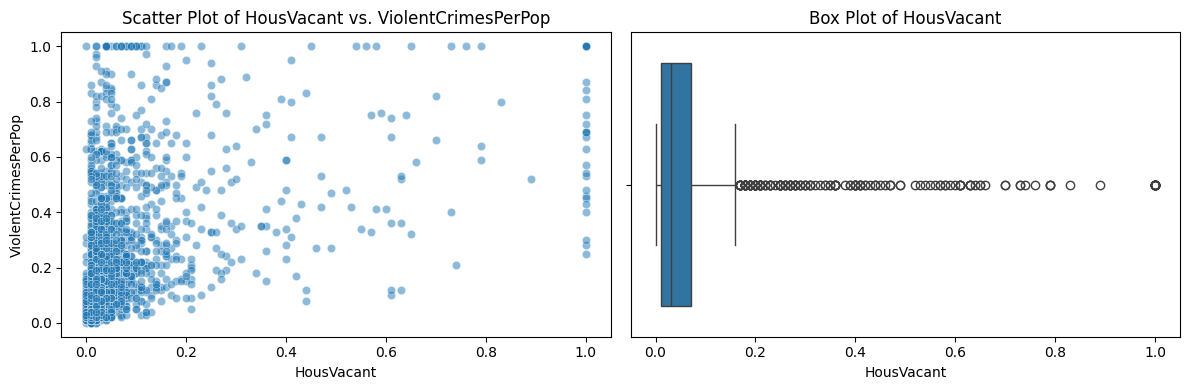

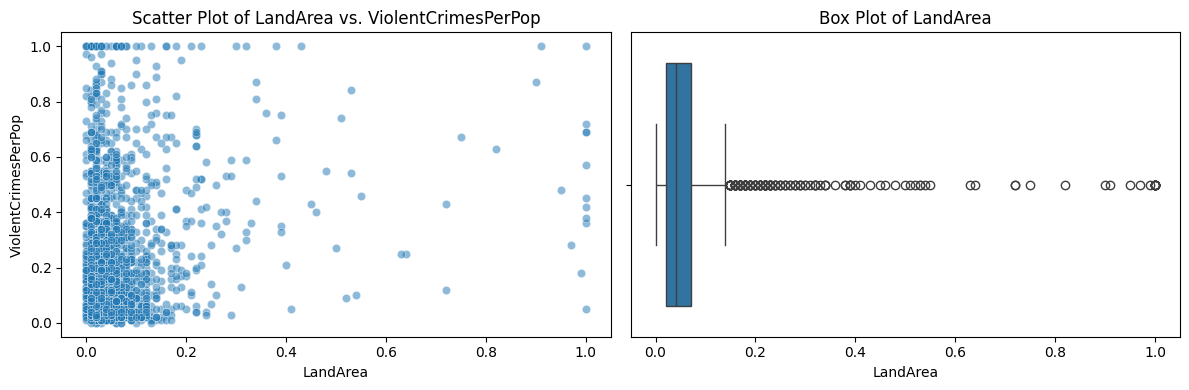

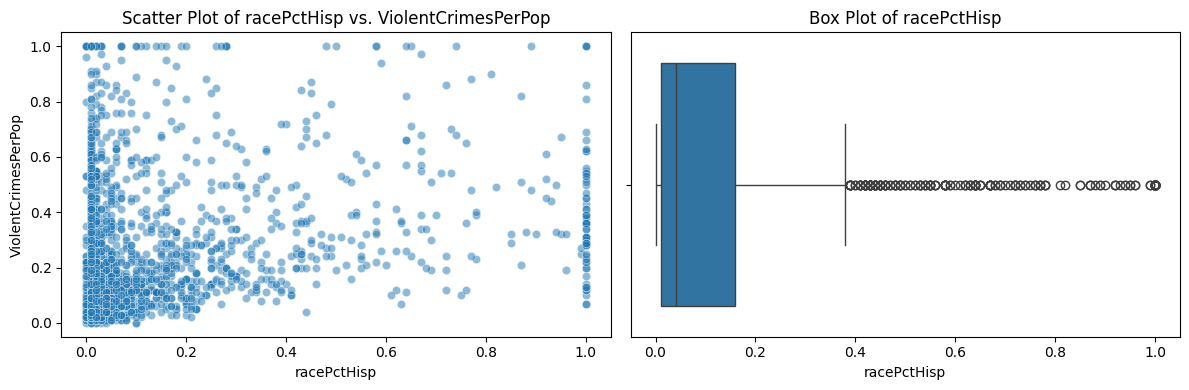

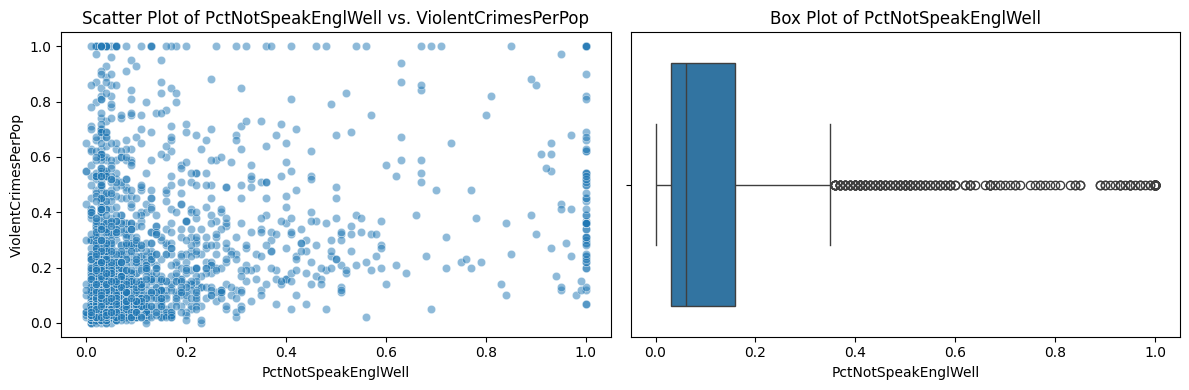

In [16]:
top_features = cv_values.nlargest(12).index  # 12 to include one additional feature for comparison

for feature in top_features:
    plt.figure(figsize=(12, 4))

    # Scatter Plot
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=df_communities, x=feature, y='ViolentCrimesPerPop', alpha=0.5)
    plt.title(f'Scatter Plot of {feature} vs. ViolentCrimesPerPop')

    # Box Plot
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_communities, x=feature)
    plt.title(f'Box Plot of {feature}')

    plt.tight_layout()
    plt.show()

**Conclusion:**<br>
Just based on scatter plots, NumInShelters, NumIlleg, NumImmg, NumUnerPov, Population and NumUrban has a stronger significance. Because we can find a pattern clear pattern between these features and ViolentCromesPerPop.

(f) Fit a linear model using least squares to the training set and report the test error.

In [17]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f"Mean Squared Error (MSE) on the test set: {mse_linear:.2f}")

Mean Squared Error (MSE) on the test set: 0.02


(g) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.


In [18]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]} 
ridge_cv = GridSearchCV(Ridge(), param_grid, cv=5)
ridge_cv.fit(X_train, y_train)
best_alpha = ridge_cv.best_params_['alpha']

ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_test)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)

print(f"Best alpha (λ) chosen by cross-validation: {best_alpha:.4f}")
print(f"Mean Squared Error (MSE) on the test set: {mse_ridge:.2f}")

Best alpha (λ) chosen by cross-validation: 1.0000
Mean Squared Error (MSE) on the test set: 0.02


(h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized features. Report the test error for both cases and compare them.

In [19]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]} 
lasso_cv = GridSearchCV(Lasso(), param_grid, cv=5)
lasso_cv.fit(X_train, y_train)
best_alpha_lasso = lasso_cv.best_params_['alpha']

lasso_model = Lasso(alpha=best_alpha)
lasso_model.fit(X_train, y_train)

y_pred_lasso = lasso_model.predict(X_test)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)

selected_variables = [feature for feature, coef in zip(top_features, lasso_model.coef_) if coef != 0]
print(f"Lasso Model (Unstandardized Features)")
print(f"Best alpha (λ) chosen by cross-validation: {best_alpha_lasso:.4f}")
print(f"Mean Squared Error (MSE) on the test set: {mse_lasso:.2f}")
print(f"Variables selected by the model: {selected_variables}")

Lasso Model (Unstandardized Features)
Best alpha (λ) chosen by cross-validation: 0.0010
Mean Squared Error (MSE) on the test set: 0.05
Variables selected by the model: []


In [20]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

lasso_cv_std = GridSearchCV(Lasso(), param_grid, cv=5)
lasso_cv_std.fit(X_train_std, y_train)
best_alpha_std = lasso_cv_std.best_params_['alpha']

lasso_model_std = Lasso(alpha=best_alpha_std)
lasso_model_std.fit(X_train_std, y_train)

y_pred_std = lasso_model_std.predict(X_test_std)
mse_std = mean_squared_error(y_test, y_pred_std)

selected_variables_std = [feature for feature, coef in zip(top_features, lasso_model_std.coef_) if coef != 0]
print("\nLasso Model (Standardized Features)")
print(f"Best alpha (λ) chosen by cross-validation: {best_alpha_std:.4f}")
print(f"Mean Squared Error (MSE) on the test set (standardized features): {mse_std:.2f}")
print(f"Variables selected by the model (standardized features): {selected_variables_std}")


Lasso Model (Standardized Features)
Best alpha (λ) chosen by cross-validation: 0.0010
Mean Squared Error (MSE) on the test set (standardized features): 0.02
Variables selected by the model (standardized features): ['NumIlleg', 'population', 'numbUrban', 'PctNotSpeakEnglWell']


Conclusion: The model with standard data has a lower mse and reasonal feature selection.

(i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

In [21]:
param_grid = {'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]} 
pca = PCA()
regressor = LinearRegression()
pipeline = Pipeline(steps=[('pca', pca), ('regressor', regressor)])
cv_pcr = GridSearchCV(pipeline, param_grid, cv=5)
cv_pcr.fit(X_train, y_train)
best_components = cv_pcr.best_params_['pca__n_components']

pca = PCA(n_components=best_components)
pcr_model = LinearRegression()
pipeline = Pipeline(steps=[('pca', pca), ('regressor', pcr_model)])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(f"Best number of principal components (M) chosen by cross-validation: {best_components}")
print(f"Mean Squared Error (MSE) on the test set: {mse:.2f}")

Best number of principal components (M) chosen by cross-validation: 10
Mean Squared Error (MSE) on the test set: 0.02


(j) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation.

In [22]:
param_grid = {'reg_alpha': [0.001, 0.01, 0.1, 1,5,6,7,8,9,10]} 
xgb_regressor = xgb.XGBRegressor()
cv_xgb = GridSearchCV(xgb_regressor, param_grid, cv=5)
cv_xgb.fit(X_train, y_train)
best_alpha = cv_xgb.best_params_['reg_alpha']

xgb_model = xgb.XGBRegressor(reg_alpha=best_alpha)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(f"Best α chosen by cross-validation: {best_alpha:.4f}")
print(f"Mean Squared Error (MSE) on the test set: {mse:.2f}")

Best α chosen by cross-validation: 5.0000
Mean Squared Error (MSE) on the test set: 0.02
